# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [68]:
import zipfile

from PIL import Image
from PIL import ImageDraw
import io
import pytesseract
import cv2 as cv
import numpy as np
import math

def check_key(d, *keys):
    '''
    Check if *keys (nested) exists in `dict_obj` (dict).
    '''
    if type(d) is not dict:
        raise AttributeError('check_key() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('check_key() expects at least two arguments, one given.')

    _item = d
    for key in keys:
        try:
            _item = _item[key]
        except KeyError:
            return False
    return True

def get_img_from_zip(zip_file, img_filename):
    img_bytes = zip_file.open(img_filename).read()
    img = Image.open(io.BytesIO(img_bytes))

    return img
    
def get_cv_parms(f):
    if check_key(img_properties, f):
        return img_properties[f]
    else:
        return img_properties['default']

def show_faces(img, faces, cropped = False):
    img_redacted = img.copy()
    
    if cropped:
        for x, y, w, h in faces:
            print((x, y, w, h))
            face_img = img_redacted.crop((x, y, x + w, y + h))
            display(face_img)
    else:
        img_draw = ImageDraw.Draw(img_redacted)

        for x, y, w, h in faces:
            img_draw.rectangle((x, y, x + w, y + h), outline="red", width = 3)

        display(img_redacted)
        
def make_collage(img, faces, plim = 100, xnum = 5): 
    img_redacted = img.copy()
    
    # defining number of rows
    rows = math.ceil(len(faces) / xnum)
    
    # prepare collage result image
    collage_img = Image.new(img_redacted.mode, (plim * xnum, plim * rows))
    
#     display(collage_img)
    
    # iterating through images
    i = 0
    xi = 0
    yi = 0
    ri = 0
    
    for x, y, w, h in faces:
#         print((x, y, w, h), img.mode)
#         print(max(w, h))
        
        # getting resize coefficient
        max_dim = max(w, h)
        
        if max_dim > plim:
            resize_coef = max_dim / plim
        else:
            resize_coef = 1
        
        wsize = int(round(w / resize_coef))
        hsize = int(round(h / resize_coef))
        
#         img_cr_orig = img_redacted.crop((x, y, x + w, y + h))
        img_cr_resized = img_redacted.crop((x, y, x + w, y + h)).resize((wsize, hsize), Image.ANTIALIAS)
#         print(resize_coef, wsize, hsize, h / resize_coef)

        # add image to collage
        xi = (i % xnum) * plim
        yi = ri * plim
        
#         print(i, xi, yi, ri)
        collage_img.paste(img_cr_resized, (xi, yi))
    
        if (i + 1) % xnum == 0:
            ri += 1

        i += 1
#         display(img_cr_orig)
#         display(img_cr_resized)
    display(collage_img)

def parse_text(img):
    # making greyscale
    img_prepared = img.convert('L')
    
    return pytesseract.image_to_string(img)

def parse_faces(img, parms, show_faces_on_img = False):
#     print(f"======== [{parms}] ========")
    
    # making greyscale
    img_prepared = img.convert("L")
    
    # convert image [PIL -> OpenCV]
    img_cv = np.array(img_prepared)
    
    # checking mandatory parameters
    if parms['scaleFactor'] > 1:
        faces = face_cascade.detectMultiScale(img_cv, **parms)
    else:
        print("Scale cannot be less than 1. Using the default scale.")
        faces = face_cascade.detectMultiScale(img_cv)
    
    if show_faces_on_img:
        show_faces(img, faces)
        
    return faces

def parse_image_data(test_mode = False, word = "Mark"):
    # loading the face detection classifier
    face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

    # zip files
    test_zip = 'readonly/small_img.zip'
    large_zip = 'readonly/images.zip'

    if test_mode:
        archive_file = test_zip
    else:
        archive_file = large_zip
    
    # Checking the Zip
    zip_archive = zipfile.ZipFile(archive_file)
    zip_archive_files = zip_archive.namelist()
#     print(zip_archive_files)

    img_properties = {
        'default': {'scaleFactor': 1.3},
        'a-0.png': {'scaleFactor': 1.35},
        'a-1.png': {'scaleFactor': 1.3151},
        'a-10.png': {'scaleFactor': 1.3},
        'a-11.png': {'scaleFactor': 1.3},
        'a-12.png': {'scaleFactor': 1.3},
        'a-13.png': {'scaleFactor': 1.3},
        'a-2.png': {'scaleFactor': 1.4},
        'a-3.png': {'scaleFactor': 1.3},
        'a-4.png': {'scaleFactor': 2}, # 1.35, 2
        'a-5.png': {'scaleFactor': 1.555}, # 1.65, 2.1555, 3.5, 1.555
        'a-6.png': {'scaleFactor': 1.6},
        'a-7.png': {'scaleFactor': 1.17, 'minSize': (100, 100)},
    }

    # process images
    i = 1
    img_info = {}

    for f in zip_archive_files:

        # temporary stub
    #     if f == 'a-0.png':
    #         True
    #     else:
    #         continue

#         print(f"[{i}/{len(zip_archive_files)}]: Processing file: [{f}]")

        # get img from zip
        img = get_img_from_zip(zip_archive, f)
        
        # parsing text
        img_text = parse_text(img)
#         print(img_text)
        
        if word not in img_text:
            i += 1
            continue
        else:
            print(f'Results found in file {f}')

        # detecting faces
        faces = parse_faces(img, get_cv_parms(f))
#         show_faces(img, faces)
#         print(faces)

        if len(faces) == 0:
            print('But there were no faces in that file!')
        else:
            make_collage(img, faces)

        i += 1

    print("Completed...")

Results found in file a-0.png


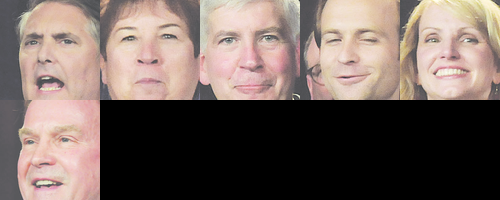

Results found in file a-1.png


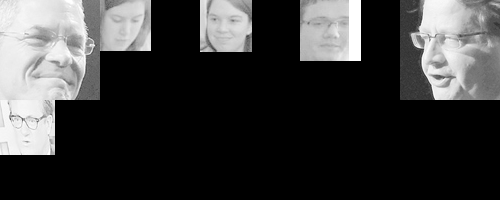

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


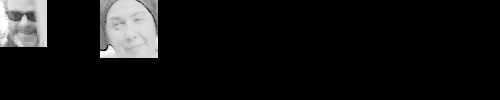

Results found in file a-2.png


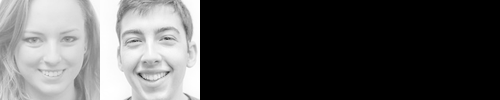

Results found in file a-3.png


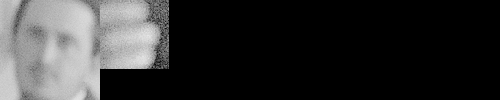

Results found in file a-8.png
But there were no faces in that file!
Completed...


In [69]:
parse_image_data(test_mode = False, word = 'Mark')